# 3D Multi-class Segmentation with UNETR  (Muscle, Fat (subcut and internal), psoas,Cavity,BGD)

## Setup environment

In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.10.dev2231
Numpy version: 1.23.1
Pytorch version: 1.12.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8236821c099e5997f7ad0410c5374e4472f4ed14
MONAI __file__: /home/adminbthomas/miniconda3/envs/PT02/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.0+cu102
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory


In [3]:
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = "/home/adminbthomas/Downloads/ensemble/unetr"# root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/adminbthomas/Downloads/ensemble/unetr


## Setup transforms for training and validation

In [4]:
import datetime
import time

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 1.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=False,   # change-intermedouts 
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
#         SaveImaged(keys="image", meta_keys="image_meta_dict", output_dir="./outMR02_Jul23_Interinputs", output_postfix=datetime.datetime.now().strftime('%f'), resample=False, separate_folder=False),
#         SaveImaged(keys="label", meta_keys="label_meta_dict", output_dir="./outMR02_Jul23_Interinputs", output_postfix=datetime.datetime.now().strftime('%f'), resample=False, separate_folder=False),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 1.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=250, b_min=0.0, b_max=1.0, clip=False
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

### DATA

In [5]:
data_dir = os.path.join(root_dir,"data/")

In [6]:
split_JSON = "dataset_MR09fold0.json"
datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset:   0%|                                                                                                                                                       | 0/12 [00:00<?, ?it/s]Modifying image pixdim from [1.4648438 1.4648438 8.        0.       ] to [  1.46484375   1.46484375   8.         281.03604124]
Modifying image pixdim from [1.4648438 1.4648438 4.        0.       ] to [  1.46484375   1.46484375   4.         268.45717811]
Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.79it/s]


## Check data shape and visualize

image shape: torch.Size([1, 250, 176, 193]), label shape: torch.Size([1, 250, 176, 193])


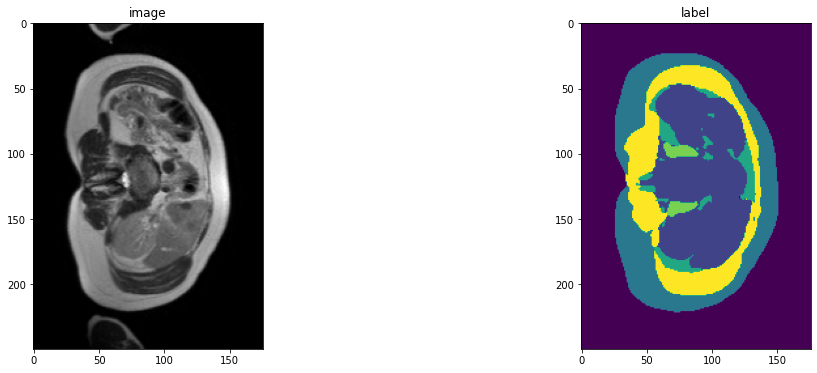

In [7]:
slice_map = {
    "A026_v1_T2W.nii.gz": 10,
    "A026_v1_T2W.nii.gz": 8,
    "A026_v1_T2W.nii.gz": 6
}
case_num = 1
img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Create Model, Loss, Optimizer


In [8]:
#### os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda:1")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=6,
    feature_size=12,
    use_checkpoint=True,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

### Execute a typical PyTorch training process

In [9]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].to(device), batch["label"].to(device))
#         print(x.shape)
#         print(y.shape)
#         plt.figure("image", (18, 6))
#         plt.subplot(1, 2, 1)
#         plt.title("image")
#         plt.imshow(x[3,0,:,:,4].detach().cpu(), cmap="gray")
#         plt.subplot(1, 2, 2)
#         plt.title("label")
#         plt.imshow(y[3,0,:,:,4].detach().cpu())
#         plt.show()
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(data_dir, "TestMR10_swinUNetR_fold0.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
        
    return global_step, dice_val_best, global_step_best


max_iterations = 70000
eval_num = 250
post_label = AsDiscrete(to_onehot=6)
post_pred = AsDiscrete(argmax=True, to_onehot=6)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
#     print('I am waiting....')
#     time.sleep(1)
model.load_state_dict(torch.load(os.path.join(data_dir, "TestMR10_swinUNetR_fold0.pth")))

Validate (X / X Steps) (dice=X.X):   0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]None of the inputs have requires_grad=True. Gradients will be None

Training (250 / 70000 Steps) (loss=2.08229):  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:14<00:02,  2.36s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5031709571679434 Current Avg. Dice: 0.5031709571679434


Training (500 / 70000 Steps) (loss=2.15397):  75%|██████████████████████████████████████████████████████████████████████████████████████▎                            | 9/12 [00:13<00:07,  2.39s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5951386094093323 Current Avg. Dice: 0.5951386094093323


Training (750 / 70000 Steps) (loss=1.35832):  58%|███████████████████████████████████████████████████████████████████                                                | 7/12 [00:11<00:12,  2.48s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6432081460952759 Current Avg. Dice: 0.6432081460952759


Training (1000 / 70000 Steps) (loss=1.09344):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:09<00:18,  2.68s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6835132241249084 Current Avg. Dice: 0.6835132241249084


Training (1250 / 70000 Steps) (loss=1.12882):  25%|████████████████████████████▌                                                                                     | 3/12 [00:08<00:29,  3.27s/it]

Model Was Saved ! Current Best Avg. Dice: 0.701724628607432 Current Avg. Dice: 0.701724628607432


Training (1500 / 70000 Steps) (loss=0.90787):   8%|█████████▌                                                                                                        | 1/12 [00:06<01:13,  6.69s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7240660587946574 Current Avg. Dice: 0.7240660587946574


Training (1750 / 70000 Steps) (loss=0.84279):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:14<00:02,  2.37s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7305048108100891 Current Avg. Dice: 0.7305048108100891


Training (2000 / 70000 Steps) (loss=0.90213):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:13<00:07,  2.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7305048108100891 Current Avg. Dice: 0.7295592625935873


Training (2250 / 70000 Steps) (loss=1.28369):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:11<00:12,  2.51s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7441705465316772 Current Avg. Dice: 0.7441705465316772


Training (2500 / 70000 Steps) (loss=0.84813):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:09<00:18,  2.70s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7458697954813639 Current Avg. Dice: 0.7458697954813639


Training (2750 / 70000 Steps) (loss=0.97644):  25%|████████████████████████████▌                                                                                     | 3/12 [00:08<00:29,  3.24s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7512105703353882 Current Avg. Dice: 0.7512105703353882


Training (3000 / 70000 Steps) (loss=0.77495):   8%|█████████▌                                                                                                        | 1/12 [00:06<01:11,  6.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7512105703353882 Current Avg. Dice: 0.7490404645601908


Training (3250 / 70000 Steps) (loss=0.69258):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:14<00:02,  2.36s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7576420903205872 Current Avg. Dice: 0.7576420903205872


Training (3500 / 70000 Steps) (loss=0.59304):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:13<00:07,  2.39s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7582374811172485 Current Avg. Dice: 0.7582374811172485


Training (3750 / 70000 Steps) (loss=0.60952):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:11<00:12,  2.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7582374811172485 Current Avg. Dice: 0.7564674814542135


Training (4000 / 70000 Steps) (loss=0.59716):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:09<00:18,  2.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7582374811172485 Current Avg. Dice: 0.756746232509613


Training (4250 / 70000 Steps) (loss=0.67955):  25%|████████████████████████████▌                                                                                     | 3/12 [00:08<00:29,  3.27s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7587346831957499 Current Avg. Dice: 0.7587346831957499


Training (4500 / 70000 Steps) (loss=0.70540):   8%|█████████▌                                                                                                        | 1/12 [00:06<01:12,  6.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7587346831957499 Current Avg. Dice: 0.756913423538208


Training (4750 / 70000 Steps) (loss=0.79231):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:14<00:02,  2.34s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7619952162106832 Current Avg. Dice: 0.7619952162106832


Training (5000 / 70000 Steps) (loss=0.68891):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:13<00:07,  2.41s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7897599736849467 Current Avg. Dice: 0.7897599736849467


Training (5250 / 70000 Steps) (loss=0.62822):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:11<00:12,  2.49s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8558903137842814 Current Avg. Dice: 0.8558903137842814


Training (5500 / 70000 Steps) (loss=0.53067):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:09<00:18,  2.68s/it]

Model Was Saved ! Current Best Avg. Dice: 0.871062695980072 Current Avg. Dice: 0.871062695980072


Training (5750 / 70000 Steps) (loss=0.49843):  25%|████████████████████████████▌                                                                                     | 3/12 [00:08<00:29,  3.31s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8768447438875834 Current Avg. Dice: 0.8768447438875834


Training (6000 / 70000 Steps) (loss=0.54266):   8%|█████████▌                                                                                                        | 1/12 [00:06<01:13,  6.71s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8800207177797953 Current Avg. Dice: 0.8800207177797953


Training (6250 / 70000 Steps) (loss=0.40876):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:14<00:02,  2.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8800207177797953 Current Avg. Dice: 0.8743019700050354


Training (6500 / 70000 Steps) (loss=0.45133):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:13<00:07,  2.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8800207177797953 Current Avg. Dice: 0.8651657104492188


Training (6750 / 70000 Steps) (loss=0.66189):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:11<00:12,  2.50s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8821340600649515 Current Avg. Dice: 0.8821340600649515


Training (7000 / 70000 Steps) (loss=0.73307):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:09<00:18,  2.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8821340600649515 Current Avg. Dice: 0.8752312064170837


Training (7208 / 70000 Steps) (loss=0.41048):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:08<00:02,  1.20it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (10250 / 70000 Steps) (loss=0.42519):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:28,  3.21s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8890654643376669 Current Avg. Dice: 0.8870520989100138


Training (10500 / 70000 Steps) (loss=0.40394):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:14,  6.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8890654643376669 Current Avg. Dice: 0.8876081109046936


Training (10750 / 70000 Steps) (loss=0.33729):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8890654643376669 Current Avg. Dice: 0.8845647772153219


Training (11000 / 70000 Steps) (loss=0.37982):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8890654643376669 Current Avg. Dice: 0.8815479477246603


Training (11250 / 70000 Steps) (loss=0.28448):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8890654643376669 Current Avg. Dice: 0.8827062447865804


Training (11500 / 70000 Steps) (loss=0.38346):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8890654643376669 Current Avg. Dice: 0.8829023639361063


Training (11750 / 70000 Steps) (loss=0.48964):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.26s/it]

Model Was Saved ! Current Best Avg. Dice: 0.889832595984141 Current Avg. Dice: 0.889832595984141


Training (12000 / 70000 Steps) (loss=0.44063):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.889832595984141 Current Avg. Dice: 0.8852574229240417


Training (12250 / 70000 Steps) (loss=0.41991):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.34s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8959446549415588


Training (12500 / 70000 Steps) (loss=0.40286):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:12<00:07,  2.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8889889121055603


Training (12750 / 70000 Steps) (loss=0.27998):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8926889499028524


Training (13000 / 70000 Steps) (loss=0.47065):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8870557347933451


Training (13250 / 70000 Steps) (loss=0.47559):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8882749478022257


Training (13500 / 70000 Steps) (loss=0.66891):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:13,  6.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8902068138122559


Training (13750 / 70000 Steps) (loss=0.40564):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8899237910906473


Training (14000 / 70000 Steps) (loss=0.38506):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8864541451136271


Training (14250 / 70000 Steps) (loss=0.37119):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8923390706380209


Training (14500 / 70000 Steps) (loss=0.39011):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8884331981341044


Training (14750 / 70000 Steps) (loss=0.47827):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:28,  3.21s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8917881846427917


Training (15000 / 70000 Steps) (loss=0.30663):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:09,  6.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8905116319656372


Training (15250 / 70000 Steps) (loss=0.26795):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8788572351137797


Training (15500 / 70000 Steps) (loss=0.29806):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:12<00:07,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8950472672780355


Training (15750 / 70000 Steps) (loss=0.36079):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8877406120300293


Training (16000 / 70000 Steps) (loss=0.38150):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8830773234367371


Training (16250 / 70000 Steps) (loss=0.40532):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.23s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8888939420382181


Training (16500 / 70000 Steps) (loss=0.34561):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:11,  6.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8908625245094299


Training (16750 / 70000 Steps) (loss=0.32155):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8929293553034464


Training (17000 / 70000 Steps) (loss=0.38067):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8915974497795105


Training (17250 / 70000 Steps) (loss=0.31272):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8922019998232523


Training (17500 / 70000 Steps) (loss=0.31319):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8948924740155538


Training (17750 / 70000 Steps) (loss=0.38924):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8891616066296896


Training (18000 / 70000 Steps) (loss=0.36290):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.891930878162384


Training (18500 / 70000 Steps) (loss=0.32176):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.887448231379191


Training (18750 / 70000 Steps) (loss=0.28016):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8845304052035013


Training (19000 / 70000 Steps) (loss=0.35398):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8840065201123556


Training (19250 / 70000 Steps) (loss=0.32844):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:28,  3.21s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8818650643030802


Training (19500 / 70000 Steps) (loss=0.22420):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:10,  6.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8831294576327006


Training (19545 / 70000 Steps) (loss=0.32654):  83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                  | 10/12 [00:09<00:01,  1.20it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (21000 / 70000 Steps) (loss=0.34478):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:11,  6.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8918475310007731


Training (21250 / 70000 Steps) (loss=0.35759):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8939715623855591


Training (21500 / 70000 Steps) (loss=0.46259):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8935236930847168


Training (21750 / 70000 Steps) (loss=0.23523):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8789181510607401


Training (22000 / 70000 Steps) (loss=0.38879):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8931665619214376


Training (22250 / 70000 Steps) (loss=0.57649):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8950143655141195


Training (22500 / 70000 Steps) (loss=0.34326):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:10,  6.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8929391702016195


Training (22750 / 70000 Steps) (loss=0.36883):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8924807906150818


Training (23000 / 70000 Steps) (loss=0.26142):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8890408674875895


Training (23250 / 70000 Steps) (loss=0.35923):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8920524915059408


Training (23500 / 70000 Steps) (loss=0.48403):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8887443939844767


Training (23750 / 70000 Steps) (loss=0.28348):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8942438761393229


Training (24000 / 70000 Steps) (loss=0.32434):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:13,  6.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8920790354410807


Training (24250 / 70000 Steps) (loss=0.39576):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959446549415588 Current Avg. Dice: 0.8923116326332092


Training (24500 / 70000 Steps) (loss=0.40829):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.39s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8971574902534485 Current Avg. Dice: 0.8971574902534485


Training (24750 / 70000 Steps) (loss=0.33652):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.49s/it]

Model Was Saved ! Current Best Avg. Dice: 0.897639811038971 Current Avg. Dice: 0.897639811038971


Training (25000 / 70000 Steps) (loss=0.34145):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.897639811038971 Current Avg. Dice: 0.8905300299326578


Training (25250 / 70000 Steps) (loss=0.34589):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.25s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.897639811038971 Current Avg. Dice: 0.8946264386177063


Training (25500 / 70000 Steps) (loss=0.41551):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:11,  6.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.897639811038971 Current Avg. Dice: 0.8965585231781006


Training (25750 / 70000 Steps) (loss=0.27888):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.897639811038971 Current Avg. Dice: 0.8956319888432821


Training (26000 / 70000 Steps) (loss=0.37637):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.897639811038971 Current Avg. Dice: 0.8950727780659994


Training (26250 / 70000 Steps) (loss=0.28978):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.897639811038971 Current Avg. Dice: 0.8929960330327352


Training (26500 / 70000 Steps) (loss=0.45804):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.897639811038971 Current Avg. Dice: 0.8892479737599691


Training (26750 / 70000 Steps) (loss=0.27123):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.25s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.897639811038971 Current Avg. Dice: 0.8924969832102457


Training (27000 / 70000 Steps) (loss=0.25402):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:09,  6.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.897639811038971 Current Avg. Dice: 0.8897011677424113


Training (27250 / 70000 Steps) (loss=0.26037):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.897639811038971 Current Avg. Dice: 0.8907650907834371


Training (27500 / 70000 Steps) (loss=0.24427):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.897639811038971 Current Avg. Dice: 0.8895626266797384


Training (27750 / 70000 Steps) (loss=0.48001):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.897639811038971 Current Avg. Dice: 0.8897859851519266


Training (28000 / 70000 Steps) (loss=0.29665):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.897639811038971 Current Avg. Dice: 0.8909005721410116


Training (28250 / 70000 Steps) (loss=0.31573):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:28,  3.22s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.897639811038971 Current Avg. Dice: 0.8924196362495422


Training (28500 / 70000 Steps) (loss=0.26751):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:13,  6.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.897639811038971 Current Avg. Dice: 0.8952836394309998


Training (28750 / 70000 Steps) (loss=0.16701):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.897639811038971 Current Avg. Dice: 0.8971676429112753


Training (29000 / 70000 Steps) (loss=0.35902):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.897639811038971 Current Avg. Dice: 0.8970757722854614


Training (29250 / 70000 Steps) (loss=0.25312):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.49s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8983484903971354 Current Avg. Dice: 0.8983484903971354


Training (29500 / 70000 Steps) (loss=0.31705):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8983484903971354 Current Avg. Dice: 0.8951562841733297


Training (29750 / 70000 Steps) (loss=0.33208):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.26s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8983484903971354 Current Avg. Dice: 0.8881718913714091


Training (30000 / 70000 Steps) (loss=0.31487):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:10,  6.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8983484903971354 Current Avg. Dice: 0.8921830654144287


Training (30250 / 70000 Steps) (loss=0.35712):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8983484903971354 Current Avg. Dice: 0.898328443368276


Training (30500 / 70000 Steps) (loss=0.32926):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8983484903971354 Current Avg. Dice: 0.8970899979273478


Training (30750 / 70000 Steps) (loss=0.30446):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.51s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8985741337140402 Current Avg. Dice: 0.8985741337140402


Training (31000 / 70000 Steps) (loss=0.28032):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8985741337140402 Current Avg. Dice: 0.8944233655929565


Training (31250 / 70000 Steps) (loss=0.33824):  25%|████████████████████████████▎                                                                                    | 3/12 [00:07<00:28,  3.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8985741337140402 Current Avg. Dice: 0.8919454415639242


Training (31500 / 70000 Steps) (loss=0.40537):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:13,  6.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8985741337140402 Current Avg. Dice: 0.8927329579989115


Training (31750 / 70000 Steps) (loss=0.34376):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8985741337140402 Current Avg. Dice: 0.8962790966033936


Training (32000 / 70000 Steps) (loss=0.41745):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8985741337140402 Current Avg. Dice: 0.8939011693000793


Training (32250 / 70000 Steps) (loss=0.31805):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8985741337140402 Current Avg. Dice: 0.8965513308842977


Training (32500 / 70000 Steps) (loss=0.32427):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8985741337140402 Current Avg. Dice: 0.8978306253751119


Training (32750 / 70000 Steps) (loss=0.33479):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.30s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8988973299662272 Current Avg. Dice: 0.8988973299662272


Training (33000 / 70000 Steps) (loss=0.29219):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:14,  6.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8988973299662272 Current Avg. Dice: 0.8924320340156555


Training (33250 / 70000 Steps) (loss=0.36004):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8988973299662272 Current Avg. Dice: 0.8978241086006165


Training (33500 / 70000 Steps) (loss=0.36632):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:12<00:07,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8988973299662272 Current Avg. Dice: 0.8943766951560974


Training (33750 / 70000 Steps) (loss=0.33948):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8988973299662272 Current Avg. Dice: 0.8985571463902792


Training (34000 / 70000 Steps) (loss=0.32650):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8988973299662272 Current Avg. Dice: 0.8942371606826782


Training (34250 / 70000 Steps) (loss=0.20287):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.24s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8988973299662272 Current Avg. Dice: 0.8964961965878805


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (41000 / 70000 Steps) (loss=0.47123):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9006997148195902 Current Avg. Dice: 0.8940046826998392


Training (41250 / 70000 Steps) (loss=0.36839):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9006997148195902 Current Avg. Dice: 0.8973911007245382


Training (41500 / 70000 Steps) (loss=0.34346):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9006997148195902 Current Avg. Dice: 0.9000516136487325


Training (41750 / 70000 Steps) (loss=0.29197):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:28,  3.21s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9006997148195902 Current Avg. Dice: 0.8963964184125265


Training (42000 / 70000 Steps) (loss=0.33406):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:11,  6.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9006997148195902 Current Avg. Dice: 0.8989007274309794


Training (42223 / 70000 Steps) (loss=0.27951):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:07<00:04,  1.17it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (47250 / 70000 Steps) (loss=0.21705):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9020817081133524 Current Avg. Dice: 0.8974664409955343


Training (47500 / 70000 Steps) (loss=0.27309):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9020817081133524 Current Avg. Dice: 0.8971396485964457


Training (47750 / 70000 Steps) (loss=0.35045):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:28,  3.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9020817081133524 Current Avg. Dice: 0.9016998807589213


Training (48000 / 70000 Steps) (loss=0.31240):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:10,  6.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9020817081133524 Current Avg. Dice: 0.899662713209788


Training (48250 / 70000 Steps) (loss=0.27443):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9020817081133524 Current Avg. Dice: 0.8945634961128235


Training (48500 / 70000 Steps) (loss=0.39395):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9020817081133524 Current Avg. Dice: 0.8993721803029379


Training (48750 / 70000 Steps) (loss=0.31255):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9020817081133524 Current Avg. Dice: 0.8947106202443441


Training (49250 / 70000 Steps) (loss=0.26865):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.25s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9020817081133524 Current Avg. Dice: 0.8985167145729065


Training (49500 / 70000 Steps) (loss=0.33839):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9020817081133524 Current Avg. Dice: 0.8990631500879923


Training (49750 / 70000 Steps) (loss=0.21085):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9020817081133524 Current Avg. Dice: 0.8937384486198425


Training (50000 / 70000 Steps) (loss=0.24104):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:12<00:07,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9020817081133524 Current Avg. Dice: 0.9007605115572611


Training (50250 / 70000 Steps) (loss=0.22232):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9020817081133524 Current Avg. Dice: 0.8982334136962891


Training (50358 / 70000 Steps) (loss=0.31754):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:06<00:04,  1.18it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (57000 / 70000 Steps) (loss=0.26360):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045566916465759 Current Avg. Dice: 0.8986577987670898


Training (57250 / 70000 Steps) (loss=0.23327):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045566916465759 Current Avg. Dice: 0.900149424870809


Training (57500 / 70000 Steps) (loss=0.36646):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045566916465759 Current Avg. Dice: 0.8990899721781412


Training (57750 / 70000 Steps) (loss=0.18345):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045566916465759 Current Avg. Dice: 0.8998255332310995


Training (58000 / 70000 Steps) (loss=0.43128):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045566916465759 Current Avg. Dice: 0.8992626468340555


Training (58127 / 70000 Steps) (loss=0.26928):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:10<00:00,  1.21it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (64750 / 70000 Steps) (loss=0.19999):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045566916465759 Current Avg. Dice: 0.8998127778371176


Training (65000 / 70000 Steps) (loss=0.30972):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045566916465759 Current Avg. Dice: 0.9003215432167053


Training (65250 / 70000 Steps) (loss=0.37805):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045566916465759 Current Avg. Dice: 0.8971954385439554


Training (65500 / 70000 Steps) (loss=0.16714):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045566916465759 Current Avg. Dice: 0.9000468055407206


Training (65750 / 70000 Steps) (loss=0.14922):  25%|████████████████████████████▎                                                                                    | 3/12 [00:07<00:28,  3.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045566916465759 Current Avg. Dice: 0.8956031004587809


Training (65936 / 70000 Steps) (loss=0.36493):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:08<00:02,  1.19it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (70000 / 70000 Steps) (loss=0.32945):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:18,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045566916465759 Current Avg. Dice: 0.8949327866236368


Training (70007 / 70000 Steps) (loss=0.29190): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:15<00:00,  1.32s/it]


<All keys matched successfully>

In [10]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)

train completed, best_metric: 0.9046 at iteration: 56250


### Plot the loss and metric

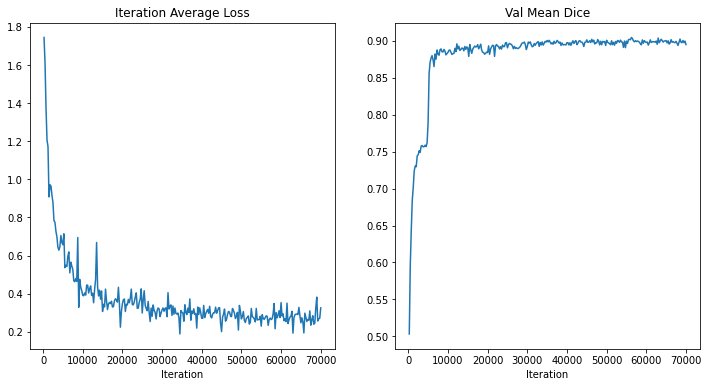

In [11]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

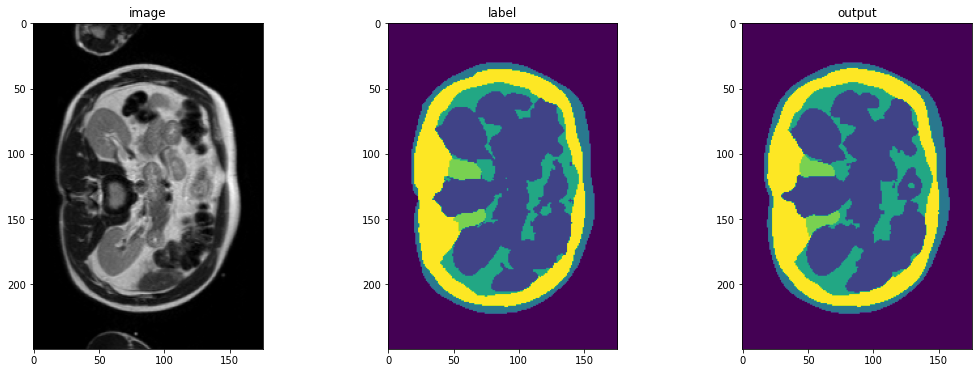

In [12]:
case_num = 0
model.load_state_dict(torch.load(os.path.join(data_dir, "TestMR10_swinUNetR_fold0.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).to(device)
    val_labels = torch.unsqueeze(label, 1).to(device)
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, 5], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, 5])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 5]
    )
    plt.show()
    

### Inference on test images

In [ ]:
import glob
from monai.data import Dataset
from monai.handlers.utils import from_engine
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)

test_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 1.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=200,
            b_min=0.0, b_max=1.0, clip=False,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys="image"),
    ]
)

test_org_ds = Dataset(
    data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=6),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./outMR10swinfold0", output_postfix="seg", resample=False, separate_folder=False),
])

In [ ]:
from monai.transforms import LoadImage
loader = LoadImage()

model.load_state_dict(torch.load(
    os.path.join(data_dir, "TestMR10_swinUNetR_fold0.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model, overlap=0.8)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_data[0]["image_meta_dict"]["filename_or_obj"])[0]

        plt.figure("check", (18, 6))
        plt.subplot(1, 4, 1)
        plt.imshow(original_image[:, :, 8], cmap="gray")
        plt.subplot(1, 4, 2)
        plt.imshow(test_output[0].detach().cpu()[2, :, :, 8])
        plt.subplot(1, 4, 3)
        plt.imshow(test_output[0].detach().cpu()[3, :, :, 8])
        plt.subplot(1, 4, 4)
        plt.imshow(test_output[0].detach().cpu()[5, :, :, 8])
        plt.show()

In [ ]:
!tar -cvzf outMR10swinfold0.tar.gz outMR10swinfold0